# SEAIR Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime
from datetime import timedelta
from scipy.integrate import solve_ivp
import matplotlib.dates as mdates



# Parameters

We consider $t$ , $t_1$ and $t_2$ counted as days. Hence , we take $t_0 = 0$ as it is the first day. Because the 12 of March comes 37 days after the 4 of February, we chose $t_1$ as a uniform law between 37 (12 of March) 
and 47 (22 of March). We can convert these days in time thanks to the facetime module. 

In [7]:

def generate_x(n):
    """ 
    Generates the parameters of the model
    """
    beta_0 = np.random.uniform(0.7,1.1,n)
    f = np.random.uniform(0.1,0.5,n)
    ln_E_0 = np.random.uniform(-np.log(10),2*np.log(10),n)
    E_0 = np.exp(ln_E_0)
    t_1 = np.random.uniform(37,47,n) #jour après t_0
    t_2 = np.random.uniform(4,20,n)
    alpha = np.random.uniform(0.3,0.7,n)
    mu = np.random.uniform(0.3,0.7,n)
    T_E = np.random.uniform(2.5,3.5,n)
    T_I = np.random.uniform(4,5,n)
    ln_gamma = np.log(0.03)+np.random.uniform(-np.log(4),np.log(4),n)
    gamma = np.exp(ln_gamma)
    
    x= np.zeros((10,n))
    x[0]= beta_0 
    x[1]= f 
    x[2]=E_0  
    x[3]= t_1 
    x[4] = t_2 
    x[5]= alpha 
    x[6]= mu 
    x[7]= T_E 
    x[8]= T_I
    x[9] = gamma
    return(x.T)
generate_x(1)

array([[8.79818010e-01, 3.40997017e-01, 4.20521095e+00, 4.07308664e+01,
        1.43448343e+01, 6.24061329e-01, 6.65273040e-01, 3.48258388e+00,
        4.80262387e+00, 3.02796195e-02]])

In [8]:
N = 67*10**6 #number of people in France
t_0 = 0 #first time
date_t_0 = datetime.strptime( '04-02-2020' , '%d-%m-%Y').date()

def to_date(t):
    """ 
    Converts a time to a date
    """
    date_t_0 =  datetime.strptime( '04-02-2020' , '%d-%m-%Y').date()
    return(date_t_0 + timedelta(days=t))

def to_number(date_str):
    """ 
    Converts a date to a time
    """
    date_str_datetime =  datetime.strptime( date_str , '%d-%m-%Y').date()
    date_t_0 =  datetime.strptime( '04-02-2020' , '%d-%m-%Y').date()
    delta=date_str_datetime-date_t_0
    return(delta.days)


# Part 1 : The SEAIR system

Here we solve the SEAIR systeme. Then we get the max number of hospitalisation by day and the final proportion of S (likely to have the Covid)


In [9]:

def generate_z_0(x):
    """ 
    Generates the intial vector  SEAIR
    """
    E_0 = x[2]  
    z_0 = np.zeros(5)
    S_0 , I_0 , A_0 , R_0 = N-E_0 , 0 , 0 , 0
    z_0 = S_0 , E_0 , I_0 , A_0 , R_0 #['S', 'E' , 'I' , 'A' , 'R' ] 
    return(z_0)



def beta(t, beta_0, f,  t_1, t_2): 
    """ 
    Function beta 
    """
    if t <= t_1:
        return(beta_0)
        
    if t> t_1 and t<=t_2+t_1:
        return( beta_0*( 1-(1-f)*(t-t_1)/t_2 ) )
    
    if t>t_2+t_1:
        return(beta_0*f)
    

def systeme_seair(t, z, x):
    """ 
    Gives the system SEAIR with the parameters as arguments
    """
   
    
    beta_0 = x[0]
    f = x[1]
    E_0 = x[2]
    t_1 = x[3]
    t_2 = x[4]
    alpha = x[5]
    mu = x[6]
    T_E = x[7]
    T_I = x[8]
    
    
    #S, E, I, A, R = max(z[0],0) , max(z[1],0), max(z[2],0), max(z[3],0), max(z[4],0)
    S, E, I, A, R = z
    
    beta_final = beta(t, beta_0, f,  t_1, t_2)

    new_S = -beta_final*S*(I+mu*A)/N
    new_E = beta_final*S*(I+mu*A)/N - E/T_E
    new_I =  alpha*E/T_E - I/T_I
    new_A = (1-alpha)*E/T_E - A/T_I
    new_R = (I+A)/T_I
    
    return [new_S, new_E , new_I , new_A , new_R ]


Here we take a x randomly chosen as the function generate-x indicates it. \
Then we perform Monte Carlo simulations for SEAIR 

In [10]:
#choice of a x random
x = generate_x(1)
x=x[0]
#x=xfin
print(x)

[1.08831346e+00 2.34612533e-01 3.76051581e-01 4.32238457e+01
 1.05606664e+01 4.25218454e-01 3.49663990e-01 2.86765054e+00
 4.53437532e+00 2.53242078e-02]


In [11]:
#equation 

tf = to_number('18-05-2020') #last date is the 1è may
t = np.arange(tf) #all integers between t_0 and tf
sol = solve_ivp(systeme_seair, [0,tf], generate_z_0(x) , args=[x],t_eval = t)
z = sol.y #prévisions
H = x[9]*z[2]/x[8] #number of hospitalisations

The blue and red horizontal lines correspond to t_1 and t_2 respectively


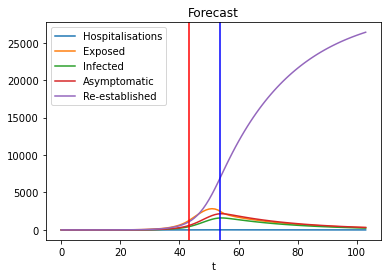

In [13]:
data_utile = z.copy()
data_utile[0] = H


#plot
plt.plot(t, data_utile.T) #nombre de rétablis
plt.axvline(x[3],color='r') #t_1
plt.axvline(x[3]+x[4],color='b') #t_1+t_2
plt.xlabel('t')
plt.legend(['Hospitalisations','Exposed','Infected','Asymptomatic','Re-established'])
plt.title('Forecast')
plt.show()


# Part 2 : Monte Carlo for hospitalisations

By Monte Carlo sampling (using the laws of the input parameters in Table 1), we display :
- the law of the maximum number of daily hospitalisations (histogram, mean, quantiles at 10% and 90%),
- the law of the final proportion of susceptible.

The maximum average number of daily hospitalisations is :  3878


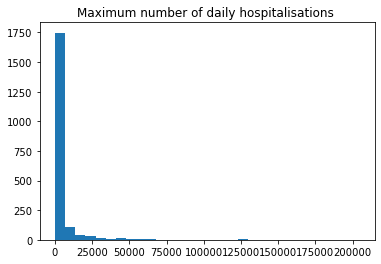

The 10% quantile is:  1.2982650331753272
The 90% quantile is:   8908.238375216473


In [14]:
n=2000 #number of simulations 
generated = generate_x(n)

def exit(n,generated):
    """ 
    Number of maximum of hospitalisations and the proportion of exposed
    """
    
    hospi_max = np.zeros(n) #max d'hospitalisations
    Proportion_susc =  np.zeros(n)
    for k in range(n):
        x = generated[k]
        sol = solve_ivp(systeme_seair, [0,tf], generate_z_0(x) , args=[x],t_eval = t)
        z = sol.y #prévisions
        H = x[9]*z[2]/x[8] #nombre d'hospitalisations
        hospi_max[k] = np.max(H) #on cherche le max d'hospitalisations
        Proportion_susc[k] = z[0][tf-1]/N
    return hospi_max, Proportion_susc

exit_1 = exit(n,generated)
hospi_max = exit_1[0]
Proportion_susc = exit_1[1]

mean_hospi = np.mean(hospi_max)
print("The maximum average number of daily hospitalisations is : ", int(mean_hospi))

plt.hist(hospi_max,bins=30)
plt.title("Maximum number of daily hospitalisations ")
plt.show()

quant_10 = np.quantile(hospi_max,0.1)
print("The 10% quantile is: ",quant_10 )

quant_90 = np.quantile(hospi_max,0.9)
print("The 90% quantile is:  ",quant_90 )

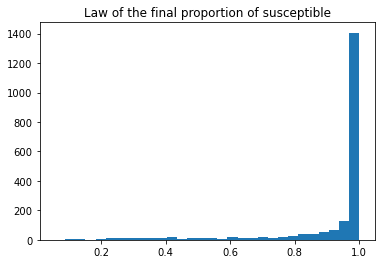

In [15]:
plt.hist(Proportion_susc,bins=30)
plt.title("Law of the final proportion of susceptible")
plt.show()

# Part 3 : Sobol indices

In [21]:
#first estimator of S_i

def estim_D(Y):
    return np.mean(Y**2) - np.mean(Y)**2

def estim_D_i(Y,Y_i):
    return (1/len(Y))*np.transpose(Y)@Y_i - np.mean(Y)**2

def estim_S_i(Y,Y_i):
    return estim_D_i(Y,Y_i) / estim_D(Y)

In [22]:
#First Order Sobol Indices de Sobol

def sobol(n):
    sample_1 = generate_x(n)
    sample_2 = generate_x(n)

    Y = exit(n,sample_1)
    Y1 = Y[0]
    Y2 = Y[1]
    var_Y1 = np.var(Y1)
    var_Y2 = np.var(Y2)

    sobol = np.zeros((10,2))

    for i in range(10) :
        new_sample = np.copy(sample_2)
        new_sample[:,i] = sample_1[:,i]
        Y_i = exit(n,new_sample)
        Y1_i = Y_i[0]
        Y2_i = Y_i[1]
        sobol[i][0] = estim_S_i(Y1,Y1_i)
        sobol[i][1] = estim_S_i(Y2,Y2_i)
    return sobol

In [23]:
#Deuxième estimateur de S_i

def estim2_D(Y,Y_i):
    return np.mean(0.5*(Y_i**2 + Y**2)) - np.mean(0.5*(Y_i + Y))**2

def estim2_D_i(Y,Y_i):
    return (1/len(Y))*np.transpose(Y)@Y_i - (np.mean(0.5*(Y_i + Y)))**2

def estim2_S_i(Y,Y_i):
    return estim2_D_i(Y,Y_i) / estim2_D(Y,Y_i)

In [24]:
def sobol2(n):
    sample_1 = generate_x(n)
    sample_2 = generate_x(n)

    Y = exit(n,sample_1)
    Y1 = Y[0]
    Y2 = Y[1]
    var_Y1 = np.var(Y1)
    var_Y2 = np.var(Y2)

    sobol = np.zeros((10,2))
    
    e = 10**2
    
    for i in range(10) :
        new_sample = np.copy(sample_2)
        new_sample[:,i] = sample_1[:,i]
        Y_i = exit(n,new_sample)
        Y1_i = Y_i[0]
        Y2_i = Y_i[1]
        sobol[i][0] = int(e*estim2_S_i(Y1,Y1_i))/e
        sobol[i][1] = int(e*estim2_S_i(Y2,Y2_i))/e
    return sobol

In [25]:
#Second estimator of S_i


def estim_D_T_i(Y,Y_tilde) : 
    return np.mean(0.5*((Y - Y_tilde)**2))

def estim_S_T_i(Y,Y_i,Y_tilde) :
    return estim_D_T_i(Y,Y_tilde) / estim2_D(Y,Y_i)

In [26]:
#Total indices
#To optimise the calculation, we calculate in the same function the
#first order indices and the total indices

def sobol(n):
    sample_1 = generate_x(n)
    sample_2 = generate_x(n)

    Y = exit(n,sample_1)
    Y1 = Y[0]
    Y2 = Y[1]
    var_Y1 = np.var(Y1)
    var_Y2 = np.var(Y2)

    sobol = np.zeros((10,2))
    sobol_T = np.zeros((10,2))
    
    e = 10**2

    for i in range(10) :
        #Start with first order
        new_sample = np.copy(sample_2)
        new_sample[:,i] = sample_1[:,i]
        Y_i = exit(n,new_sample)
        Y1_i = Y_i[0]
        Y2_i = Y_i[1]
        sobol[i][0] = int(e*estim2_S_i(Y1,Y1_i))/e
        sobol[i][1] = int(e*estim2_S_i(Y2,Y2_i))/e
        
        #Then total indices
        new_sample_2 = np.copy(sample_1)
        new_sample_2[:,i] = sample_2[:,i]
        Y_tilde = exit(n,new_sample_2)
        Y1_tilde = Y_tilde[0]
        Y2_tilde = Y_tilde[1]
        sobol_T[i][0] = int(e*estim_S_T_i(Y1,Y1_i,Y1_tilde))/e
        sobol_T[i][1] = int(e*estim_S_T_i(Y2,Y2_i,Y2_tilde))/e
    return sobol,sobol_T


In [27]:
n=500
S,S_T = sobol(n)

print('Sensitivity analysis for the number of' + "'" + 'hospitalizations max :')
print('First order indices S_i / Total indices S_T_i')
print(' beta_0, S_1 = ' + str(S[0][0]) + '   '
      '|  S_T_1 = ' + str(S_T[0][0]))
print(' f, S_2 = ' + str(S[1][0]) + '   '
     '|  S_T_2 = ' + str(S_T[1][0]))
print(' E_0, S_3 = ' + str(S[2][0]) + '   '
     '|  S_T_3 = ' + str(S_T[2][0]))
print(' t_1, S_4 = ' + str(S[3][0]) + '   '
     '|  S_T_4 = ' + str(S_T[3][0]))
print(' t_2, S_5 = ' + str(S[4][0]) + '   '
     '|  S_T_5 = ' + str(S_T[4][0]))
print(' alpha, S_6 = ' + str(S[5][0]) + '   '
     '|  S_T_6 = ' + str(S_T[5][0]))
print(' mu, S_7 = ' + str(S[6][0]) + '   '
     '|  S_T_7 = ' + str(S_T[6][0]))
print(' T_E, S_8 = ' + str(S[7][0]) + '   '
     '|  S_T_8 = ' + str(S_T[7][0]))
print(' T_I, S_9 = ' + str(S[8][0]) + '   '
     '|  S_T_9 = ' + str(S_T[8][0]))
print(' gamma, S_10 = ' + str(S[9][0]) + '   '
     '|  S_T_10 = ' + str(S_T[9][0]))

print('')
print('--------')
print('')

print('Sensitivity analysis for the proportion susceptible :')
print('First order indices S_i / Total indices S_T_i')
print(' beta_0, S_1 = ' + str(S[0][1]) + '   '
      '|  S_T_1 = ' + str(S_T[0][1]))
print(' f, S_2 = ' + str(S[1][1]) + '   '
     '|  S_T_2 = ' + str(S_T[1][1]))
print(' E_0, S_3 = ' + str(S[2][1]) + '   '
     '|  S_T_3 = ' + str(S_T[2][1]))
print(' t_1, S_4 = ' + str(S[3][1]) + '   '
     '|  S_T_4 = ' + str(S_T[3][1]))
print(' t_2, S_5 = ' + str(S[4][1]) + '   '
     '|  S_T_5 = ' + str(S_T[4][1]))
print(' alpha, S_6 = ' + str(S[5][1]) + '  '
     '|  S_T_6 = ' + str(S_T[5][1]))
print(' mu, S_7 = ' + str(S[6][1]) + '    '
     '|  S_T_7 = ' + str(S_T[6][1]))
print(' T_E, S_8 = ' + str(S[7][1]) + '    '
     '|  S_T_8 = ' + str(S_T[7][1]))
print(' T_I, S_9 = ' + str(S[8][1]) + '    '
     '|  S_T_9 = ' + str(S_T[8][1]))
print(' gamma, S_10 = ' + str(S[9][1]) + '   '
     '|  S_T_10 = ' + str(S_T[9][1]))

Sensitivity analysis for the number of'hospitalizations max :
First order indices S_i / Total indices S_T_i
 beta_0, S_1 = 0.06   |  S_T_1 = 0.53
 f, S_2 = 0.04   |  S_T_2 = 0.11
 E_0, S_3 = 0.07   |  S_T_3 = 0.2
 t_1, S_4 = 0.05   |  S_T_4 = 0.03
 t_2, S_5 = 0.04   |  S_T_5 = 0.02
 alpha, S_6 = 0.03   |  S_T_6 = 0.23
 mu, S_7 = 0.05   |  S_T_7 = 0.08
 T_E, S_8 = 0.05   |  S_T_8 = 0.04
 T_I, S_9 = 0.04   |  S_T_9 = 0.04
 gamma, S_10 = 0.14   |  S_T_10 = 0.26

--------

Sensitivity analysis for the proportion susceptible :
First order indices S_i / Total indices S_T_i
 beta_0, S_1 = 0.15   |  S_T_1 = 0.52
 f, S_2 = 0.1   |  S_T_2 = 0.24
 E_0, S_3 = 0.09   |  S_T_3 = 0.37
 t_1, S_4 = 0.04   |  S_T_4 = 0.03
 t_2, S_5 = 0.04   |  S_T_5 = 0.03
 alpha, S_6 = 0.05  |  S_T_6 = 0.23
 mu, S_7 = 0.1    |  S_T_7 = 0.16
 T_E, S_8 = 0.06    |  S_T_8 = 0.04
 T_I, S_9 = 0.04    |  S_T_9 = 0.05
 gamma, S_10 = 0.03   |  S_T_10 = 0.0


# Part 4 : Import State data

In [28]:
codes_regions = pd.read_csv('codes-regions.csv',sep=';')
liste_codes = codes_regions.iloc[:,0].values
liste_codes = np.unique(liste_codes)
liste_codes

array([ 1,  2,  3,  4,  6, 11, 24, 27, 28, 32, 44, 52, 53, 75, 76, 84, 93,
       94])

In [29]:
df=pd.read_csv('donnees-hospitalieres-classe-age-hebdo-covid19-2022-02-24-19h05.csv',sep=';')
data = df[df['cl_age90']==0]
data= data.iloc[:,[0,1,3]] #supp classe d'age
data = data[(data['Semaine']>='2020-S09') & (data['Semaine']<='2020-S20')] #We select the good weeks

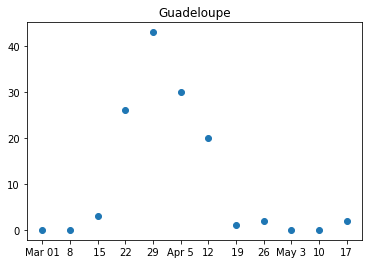

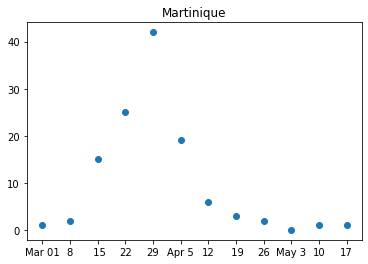

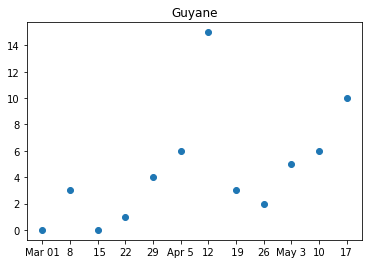

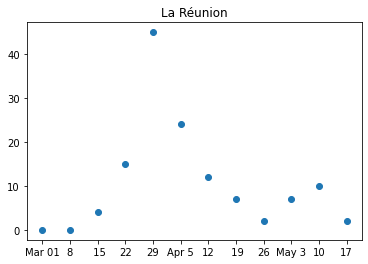

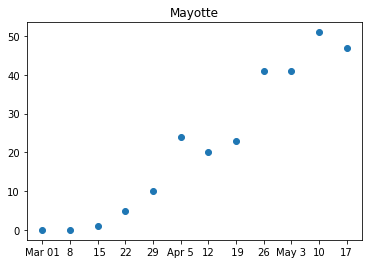

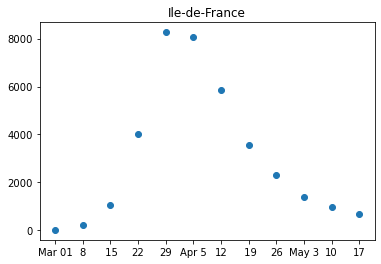

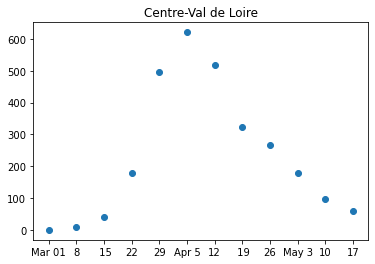

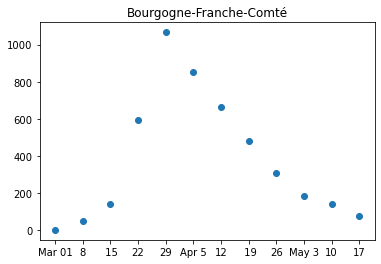

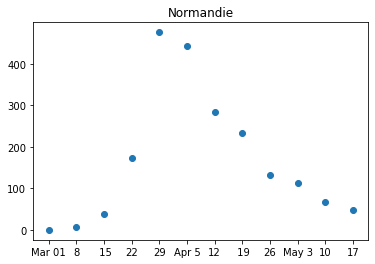

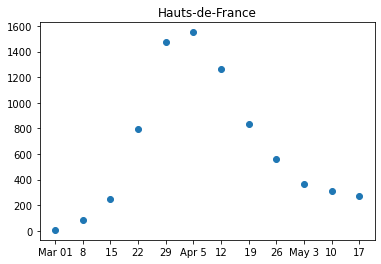

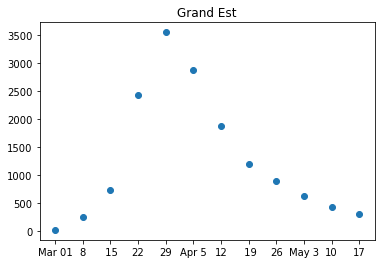

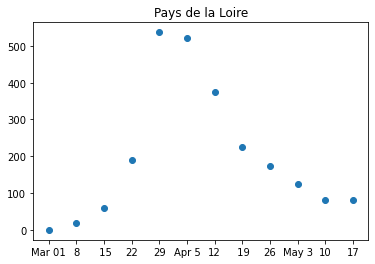

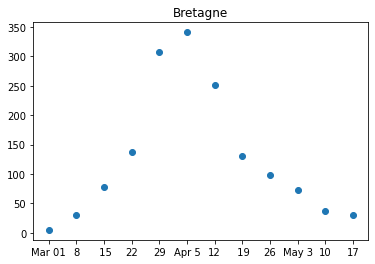

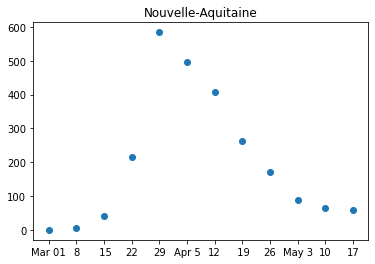

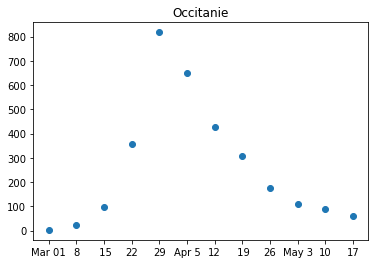

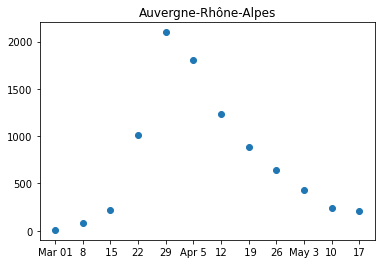

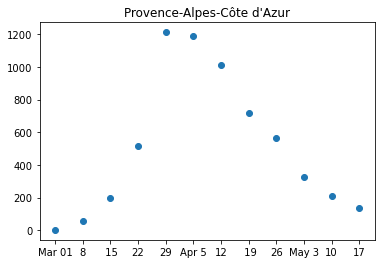

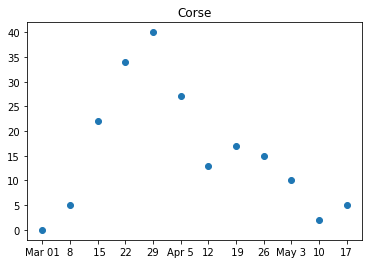

In [30]:

n_regions= len(liste_codes)
jours = ["Mar 01", "8"," 15","22", "29", "Apr 5", "12"," 19","26", "May 3","10","17"]
for i in range(n_regions):
    new_region = data[data['reg']==liste_codes[i]]
    new_region= new_region.groupby(by=["Semaine"]).sum() #Age classes
    plt.scatter(jours,new_region['NewAdmHospit'].values)
    plt.title(codes_regions[codes_regions['Nouveau Code']==liste_codes[i]].iloc[0,1])
    plt.show()

# Part 5 : Prediction by state

We chose a region (IDF) and numerically evaluated $x^*$ in the domain of $R^6$ determined by the support of the a priori laws . We compare on a figure the data and the predictions $M_{H7}(x^∗,-)$. Give the values $R_0^∗$ and $γ^∗$ thus obtained.

In [31]:
region_IDF = data[data['reg']==11]
region_IDF= region_IDF.groupby(by=["Semaine"]).sum() #on fusionne les classes d'ages
data_IDF= region_IDF['NewAdmHospit'].values
data_IDF

array([   5,  223, 1028, 4012, 8268, 8065, 5851, 3550, 2319, 1371,  954,
        673])

In the following, we will look more closely at the following seven parameters: $β_0$,
$f$, $E_0$, $t_1$, $t_2$, $γ$ and we freeze the others: $T_E = 3$ , $T_I = 5$, $µ = 0.5$ , $α = 0.5.$

In [33]:

def generate_new_x(n):
    """ 
    generation of a new x with the frozen parameters
    """
    beta_0 = np.random.uniform(0.7,1.1,n)
    f = np.random.uniform(0.1,0.5,n)
    ln_E_0 = np.random.uniform(-np.log(10),2*np.log(10),n)
    E_0 = np.exp(ln_E_0)
    t_1 = np.random.uniform(37,47,n) #jour après t_0
    t_2 = np.random.uniform(4,20,n)
    #alpha = np.zeros(n)+0.5
    #mu = np.zeros(n)+0.5
    #T_E = np.zeros(n)+3
    #T_I = np.zeros(n)+5
    ln_gamma = np.log(0.03)+np.random.uniform(-np.log(4),np.log(4),n)
    gamma = np.exp(ln_gamma)
    
    x= np.zeros((6,n))
    x[0]= beta_0 
    x[1]= f 
    x[2]=E_0  
    x[3]= t_1 
    x[4] = t_2 
    #x[5]= alpha 
    #x[6]= mu 
    #x[7]= T_E 
    #x[8]= T_I
    x[5] = gamma
    return(x.T)

#liste des entiers et dernière data
t_i = to_number('24-02-2020') #le premier jour de la semaine avant le 1er mars
tf = to_number('18-05-2020') #on prend une date finale qui est le 17 mai
t = np.arange(tf) #tous les entiers entre le t_0 et tf



def admissions_hospi(x):
    """ 
    generation of a the admissions with the frozen parameters
    """
    y= np.zeros(10)
    alpha = 0.5
    mu = 0.5
    T_E = 3
    T_I = 5

    y[:5]= x[:5]
    y[5]= alpha 
    y[6]= mu 
    y[7]= T_E 
    y[8]= T_I
    y[9] = x[5]
    
    
    sol = solve_ivp(systeme_seair, [0,tf], generate_z_0(y) , args=[y],t_eval = t)
    z = sol.y #prévisions
    H = y[9]*z[2][t_i:tf]/y[8] #nombre d'hospitalisations entre le 23 fevrier et le 17 mai 
    H_agrege = np.cumsum(H)
    H_indices = np.zeros(12) #la prevision au moment des 
    for i in range(1,13):
        if i==1:
             H_indices[i-1]= H_agrege[i*7-1] #concerne la première semaine
        else:
            H_indices[i-1]= H_agrege[i*7-1]-H_agrege[(i-1)*7-1] #les autres semaines
    return(H_indices)

def residu(adm_hospi,i,data_IDF):
    """ residue"""
    return((adm_hospi[i]-data_IDF[i])/np.sqrt(adm_hospi[i]))

def a_minimiser(x):
    """ 
    The loss to minimise is the sum of each residues by region
    """
    s=0
    adm_hospi = admissions_hospi(x)
    for i in range(12):
        s+=residu(adm_hospi,i,data_IDF)**2
    return(s)
        
x=generate_new_x(1)[0]
print(x)
a_minimiser(x)
    
    

[ 0.98955492  0.42615843  0.31943701 41.7379081   6.68809082  0.04716845]


630183.0520529562

### Loss minimisation

In [34]:
from scipy.optimize import minimize
def findx0():
    """
    We find a first x suitable by a Small Monte Carlo
    """
    xfin=generate_new_x(1)[0]
    ffin = a_minimiser(xfin)
    for i in range(50):  
        xtest=generate_new_x(1)[0]
        ftest = a_minimiser(xtest)
        if ftest<ffin:
            xfin=xtest
            ffin=ftest
    return(xfin)

def findx1():
    """
    We start the scipy optimisation with the previous x found b y MC
    """
    xfin1=findx0()
    ffin1 = a_minimiser(xfin1)
    for i in range(5):
        xfin = findx0()
        res = minimize(a_minimiser, xfin, method='Nelder-Mead', tol=1e-6)
        ffin = a_minimiser(res.x)
        
        if ffin<ffin1:
            xfin1=res.x
            ffin1=ffin
        
    return(xfin1)


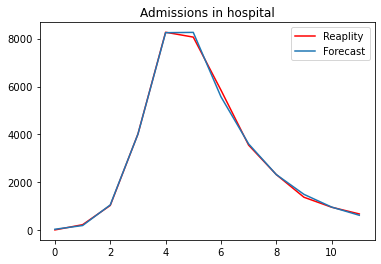

In [35]:
testx=findx1()
plt.plot(data_IDF,color="r")
plt.plot(admissions_hospi(testx))
plt.title("Admissions in hospital")
plt.legend(['Reaplity','Forecast'])
plt.show()


We obtain the following values of $R_0^*$ and $\gamma^*$ : 

In [36]:
print("R_0 = ",0.5*(1.5)*testx[0]*5)
print("gamma = ",testx[5])


R_0 =  3.951545938600175
gamma =  0.050326500319154005


# Part 6 :  a small calculation

Let's show that we have :
\begin{equation}
{\sigma ^ *} ^ {2} = \frac{1}{n_{H7}} \sum_{i=1}^{n_{H7}} f_{H7} (x^*, s_i)
\end{equation}



We want to minimize $p(data|x,\sigma)$ , let derive the expression  $p(data|x,\sigma)$ in relation to $\sigma$, and seeks to annul this derivative, we obtain : 
\begin{equation}
\frac{- n_{H7}}{\sigma ^ *} + \frac{1}{{\sigma^*}^{3}} \sum_{i=1}^{n_{H7}} f_{H7} (x^*, s_i) =0
\end{equation}

So  $\sigma^*$ :

\begin{equation}
{\sigma ^ *} ^ {2} = \frac{1}{n_{H7}} \sum_{i=1}^{n_{H7}} f_{H7} (x^*, s_i)
\end{equation}


# Part 8: Same method on each region

In [37]:

n_regions= len(liste_codes)

def data_region(data,region):
    region+=5
    new_region = data[data['reg']==liste_codes[region]]
    new_region= new_region.groupby(by=["Semaine"]).sum() #on fusionne les classes d'ages
    new_region= new_region['NewAdmHospit'].values
    return(new_region)


In [38]:

def generate_new_x_total(n):
    
    x= np.zeros((17,n))
    
    beta_0 = np.random.uniform(0.7,1.1,n)
    f = np.random.uniform(0.1,0.5,n)
    
    t_1 = np.random.uniform(37,47,n) #jour après t_0
    t_2 = np.random.uniform(4,20,n)

    ln_gamma = np.log(0.03)+np.random.uniform(-np.log(4),np.log(4),n)
    gamma = np.exp(ln_gamma)
    
    for i in range(12):
        ln_E_0 = np.random.uniform(-np.log(10),2*np.log(10),n)
        E_0 = np.exp(ln_E_0)
        x[i+5]=E_0 
    
    
    x[0]= beta_0 
    x[1]= f 
    x[2]= t_1 
    x[3] = t_2 
    x[4] = gamma
    
    
    return(x.T)

#liste des entiers et dernière data
t_i = to_number('24-02-2020') #le premier jour de la semaine avant le 1er mars
tf = to_number('18-05-2020') #on prend une date finale qui est le 17 mai
t = np.arange(tf) #tous les entiers entre le t_0 et tf



def admissions_hospi_total(x,region):
    y= np.zeros(10)
    alpha = 0.5
    mu = 0.5
    T_E = 3
    T_I = 5

    
    y[0]= x[0]  #beta
    y[1]= x[1] #f
    y[2]= x[5+region] #E_0 i
    y[3]= x[2] #t1 
    y[4]= x[3] #t2
    
    y[5]= alpha 
    y[6]= mu 
    y[7]= T_E 
    y[8]= T_I
    y[9] = x[4] #gamma
    
    
    sol = solve_ivp(systeme_seair, [0,tf], generate_z_0(y) , args=[y],t_eval = t)
    z = sol.y #prévisions
    H = y[9]*z[2][t_i:tf]/y[8] #nombre d'hospitalisations entre le 23 fevrier et le 17 mai 
    is_ok = True #parfois problème dans prévision
    if len(H)==84:
        H_agrege = np.cumsum(H)
        H_indices = np.zeros(12) #la prevision au moment des 
        for i in range(1,13):
            if i==1:
                 H_indices[i-1]= H_agrege[i*7-1] #concerne la première semaine
            else:
                H_indices[i-1]= H_agrege[i*7-1]-H_agrege[(i-1)*7-1] #les autres semaines
    else : 
        H_indices = np.zeros(12)
        is_ok = False
        
    return(H_indices,is_ok)

def residu_total(adm_hospi,i,data,region):
    new_region = data_region(data,region)
    return((adm_hospi[i]-new_region[i])/np.sqrt(adm_hospi[i]))

def a_minimiser_total(x):
    s=0
    for k in range(12):
        adm_hospi = admissions_hospi_total(x,k)[0]
        for i in range(12):
            if admissions_hospi_total(x,k)[1]:
                s+=residu_total(adm_hospi,i,data,k)**2
    return(s)
        
x=generate_new_x_total(1)[0]
print(x)
a_minimiser_total(x)
    
    

[ 1.07734038  0.30347064 38.69718252 13.01972209  0.10501107 79.5914868
  0.10473269 24.41585436  6.57018611  2.39103452 21.07848075  0.37057045
 21.06126163  1.12209205  2.48531574  0.59637423  1.05489074]


5427529.538771551

The methods are same as before : 

In [39]:

def findx0_total():
    xfin=generate_new_x_total(1)[0]
    ffin = a_minimiser_total(x)
    for i in range(10):  
        xtest=generate_new_x_total(1)[0]
        ftest = a_minimiser_total(xtest)
        if ftest<ffin:
            xfin=xtest
            ffin=ftest
    return(xfin)

def findx1_total():
    xfin1=findx0_total()
    ffin1 = a_minimiser_total(xfin1)
    for i in range(2):
        xfin = findx0_total()
        res = minimize(a_minimiser, xfin, method='Nelder-Mead', tol=1e-6)
        ffin = a_minimiser_total(res.x)
        
        if ffin<ffin1:
            xfin1=res.x
            ffin1=ffin

    return(xfin1)
#plt.plot(admissions_hospi(res.x))
#print(a_minimiser(res.x))

In [40]:
testx= findx1_total()

11


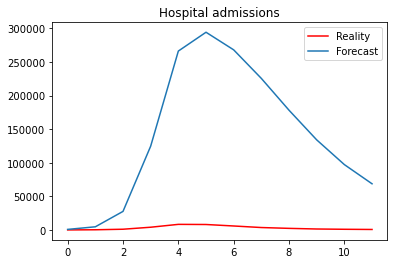

24


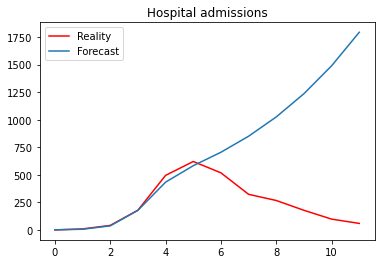

27


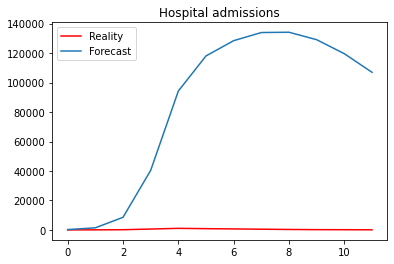

28


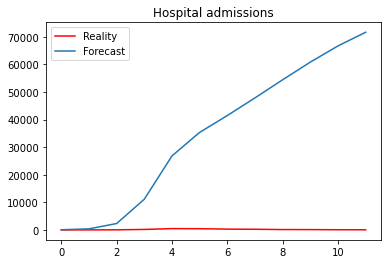

32


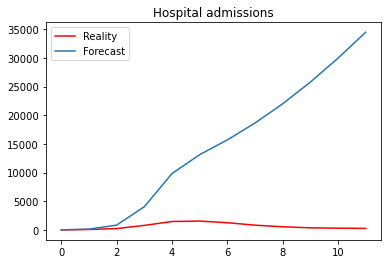

44


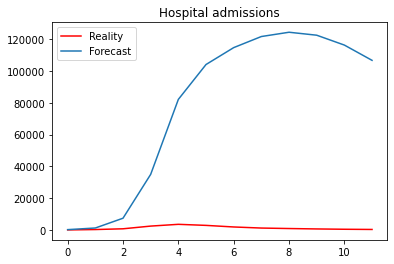

52


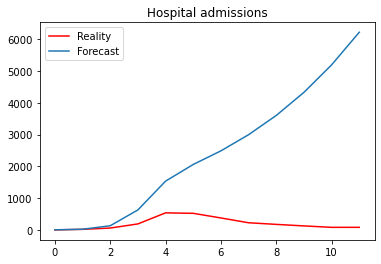

53


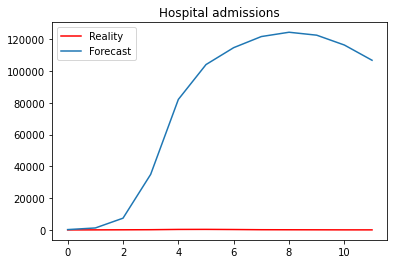

75


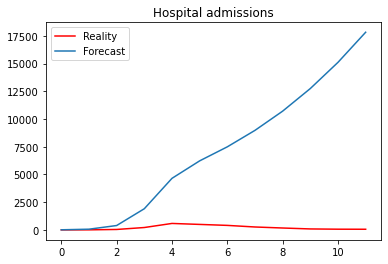

76


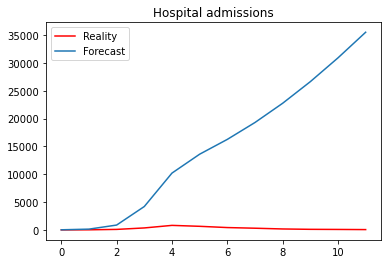

84


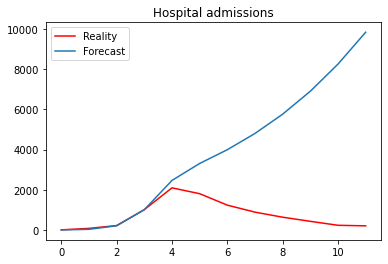

93


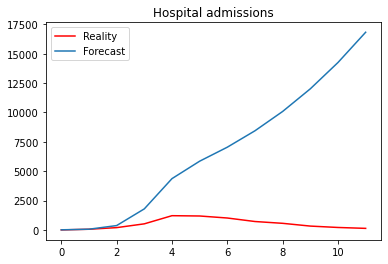

In [41]:
a_minimiser_total(testx)
for i in range(12):
    print(liste_codes[i+5])
    plt.plot(data_region(data,i),color="r")
    plt.plot(admissions_hospi_total(x,i)[0])
    plt.title("Hospital admissions")
    plt.legend(['Reality','Forecast'])
    plt.show()


In [42]:
print("The optimal x is:")
print("beta:",testx[0])
print("f:",testx[1])
print("t_1:",testx[2])
print("t_2:",testx[3])
print("gamma:",testx[4])
print("List of each E_0 :")
for i in range(12):
    print(" ")
    print(codes_regions[codes_regions['Nouveau Code']==liste_codes[i+5]].iloc[0,1])
    print(testx[i+5])

The optimal x is:
beta: 0.9529859555440309
f: 0.296374661901763
t_1: 39.78107060164883
t_2: 9.793244985180694
gamma: 0.0671098585887202
List of each E_0 :
 
Ile-de-France
0.9264637787187827
 
Centre-Val de Loire
0.1819938667140498
 
Bourgogne-Franche-Comté
15.858702453120918
 
Normandie
15.743562695167059
 
Hauts-de-France
1.7885955708915946
 
Grand Est
1.9984604409101374
 
Pays de la Loire
0.5461276304853852
 
Bretagne
26.831805431065114
 
Nouvelle-Aquitaine
1.2514190922648947
 
Occitanie
1.5586942860098842
 
Auvergne-Rhône-Alpes
9.51705871255913
 
Provence-Alpes-Côte d'Azur
2.030570846236094


In [232]:
a_minimiser_total(testx)

235724.29278344748


The method is not very effective in larger dimensions. 